### Colab 연결

In [ ]:
# Colab과 연결

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Required Modules

In [ ]:
# Path, OS
import os
from pathlib import Path
import shutil

# matrix 계산
import numpy as np

# Similarity 계산
import cv2
from sklearn.metrics.pairwise import cosine_similarity

# Check type of Image to prevent data corruption
import imghdr

# Data split
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf

# Directory에서 Category별 Image 처리
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils import shuffle

# Model 생성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50

# Model layer
from tensorflow.keras import layers

# Optimizer
from tensorflow.keras.optimizers import Adam

# Visualization
import matplotlib.pyplot as plt

# Accuracy
from sklearn.metrics import accuracy_score

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Path Setting & Image Pre-Processing

In [ ]:
# 총 9개의 category
categories = ['Bench Press', 'Dumbbells', 'Elliptical Machine', 'Kettlebells',
              'Lat Pulldowns', 'Leg Curls', 'Leg Press',  'Recumbent Bike', 'Smith Machine']

category_num = len(categories)


# category별 file number count
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Gym_Equips_temp/'):
  count = 0
  for filename in filenames:
    count += 1
    #print(os.path.join(dirname, filename))
  print(f"{count} files in {dirname}")
  print()

0 files in /content/drive/MyDrive/Gym_Equips_temp/

69 files in /content/drive/MyDrive/Gym_Equips_temp/Dumbbells

96 files in /content/drive/MyDrive/Gym_Equips_temp/Elliptical Machine

78 files in /content/drive/MyDrive/Gym_Equips_temp/Recumbent Bike

108 files in /content/drive/MyDrive/Gym_Equips_temp/Smith Machine

109 files in /content/drive/MyDrive/Gym_Equips_temp/Leg Press

89 files in /content/drive/MyDrive/Gym_Equips_temp/Bench Press

71 files in /content/drive/MyDrive/Gym_Equips_temp/Lat Pulldowns

119 files in /content/drive/MyDrive/Gym_Equips_temp/Leg Curls

108 files in /content/drive/MyDrive/Gym_Equips_temp/Kettlebells



In [ ]:
# 중복되는 이미지를 찾기 위한 function predefine

# Image Loading and Normalizing function
def load_and_normalize_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return None
    image = cv2.resize(image, (224, 224))

    # Normalize
    normalized_image = image / 255.0

    # Flatten
    return normalized_image.flatten()


# Image Comparison function
def compare_images(img1, img2):
    # Compare similarity using cosine similarity.
    return cosine_similarity([img1], [img2])[0][0]

# Deleting similar image function
def find_and_delete_similar_images(category_path, similarity_threshold=0.9):
    images = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    normalized_images = {}
    to_delete = set()

    # Load and normalize all images
    for img_path in images:
        normalized_images[img_path] = load_and_normalize_image(img_path)

    # Compare images and identify those to delete
    for i, img1 in enumerate(images):
        if img1 in to_delete:  # Skip if already marked for deletion
            continue
        for j, img2 in enumerate(images):
            if i >= j or img2 in to_delete:  # Avoid duplicate comparisons or already marked
                continue
            sim = compare_images(normalized_images[img1], normalized_images[img2])
            if sim >= similarity_threshold:
                to_delete.add(img2)

    # Delete marked images
    for img_path in to_delete:
        os.remove(img_path)
        print(f"Deleted: {img_path}")

    # Print results
    print(f"Processed category '{os.path.basename(category_path)}':")
    print(f"  Retained images: {len(images) - len(to_delete)}")
    print(f"  Deleted images: {len(to_delete)}")

# Finding similar image function
def find_similar_images_in_category(category_path, similarity_threshold=0.9):
    """
    Find similar images within a single category directory based on RGB normalization.
    """
    images = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    normalized_images = {}

    # Load and normalize all images
    for img_path in images:
        normalized_images[img_path] = load_and_normalize_image(img_path)

    similar_images = []
    for i, img1 in enumerate(images):
        for j, img2 in enumerate(images):
            if i >= j:  # Avoid duplicate comparisons
                continue
            sim = compare_images(normalized_images[img1], normalized_images[img2])
            if sim >= similarity_threshold:
                similar_images.append((img1, img2, sim))

    if similar_images:
        print(f"Similar images found in category '{os.path.basename(category_path)}':")
        for img1, img2, sim in similar_images:
            print(f"  {os.path.basename(img1)} and {os.path.basename(img2)} - Similarity: {sim:.2f}")
    else:
        print(f"No similar images found in category '{os.path.basename(category_path)}'.")



In [ ]:
# 중복되는 이미지 삭제, 이미지 비교에 시간이 오래 걸리기 때문에 image들을 업데이트한 후 정리할 때만 run

# Implementation of find_and_delete_similar_images
# category_path = '/content/drive/MyDrive/Gym_Equips_temp/'
# similarity_threshold = 0.99

# for cat in categories:
#     category_dir = os.path.join(category_path, str(cat))
#     find_and_delete_similar_images(category_dir, similarity_threshold)

Processed category 'Bench Press':
  Retained images: 89
  Deleted images: 0
Processed category 'Dumbbells':
  Retained images: 69
  Deleted images: 0
Processed category 'Elliptical Machine':
  Retained images: 96
  Deleted images: 0
Processed category 'Kettlebells':
  Retained images: 108
  Deleted images: 0
Processed category 'Lat Pulldowns':
  Retained images: 71
  Deleted images: 0
Processed category 'Leg Curls':
  Retained images: 119
  Deleted images: 0
Processed category 'Leg Press':
  Retained images: 109
  Deleted images: 0
Processed category 'Recumbent Bike':
  Retained images: 78
  Deleted images: 0
Processed category 'Smith Machine':
  Retained images: 108
  Deleted images: 0


In [ ]:
# category 안에 중복되는 이미지 검토

category_path = '/content/drive/MyDrive/Gym_Equips_temp/'
similarity_threshold = 0.99  # Set the similarity threshold for RGB comparison

# Find similar images in the given category
for cat in categories:
  find_similar_images_in_category(os.path.join(category_path, str(cat)), similarity_threshold)


No similar images found in category 'Bench Press'.
No similar images found in category 'Dumbbells'.
No similar images found in category 'Elliptical Machine'.
No similar images found in category 'Kettlebells'.
No similar images found in category 'Lat Pulldowns'.
No similar images found in category 'Leg Curls'.
No similar images found in category 'Leg Press'.
No similar images found in category 'Recumbent Bike'.
No similar images found in category 'Smith Machine'.


In [ ]:
# full dataset 디렉토리
dataset_dir = '/content/drive/MyDrive/Gym_Equips_temp'

image_extensions = [".png", ".jpg", "jpeg"]

# tensorflow에서 인식 가능한 확장자
img_type_accepted_by_tf = ["bmp","jpeg", "png"]
for filepath in Path(dataset_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        # image data가 image가 아닐 때 삭제 후 확인
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
            if os.path.isfile(filepath):
                print("File still Exists")

        # image data가 tensorflow에서 인식되지 않는 type일 때 삭제 후 확인
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            if os.path.isfile(filepath):
                print("File still Exists")
        else:
            pass


In [ ]:
# 해당 셀은 full dataset(전체 데이터)을 data를 category별 6:2:2로 split한다.
# split된 data는 각각 training/해당category, valivation/해당category, test/해당category 에 저장된다.

if(os.path.isdir('./dataset')):
    print(f"dataset 디렉토리가 이미 존재하여 새로운 dataset 디렉토리를 만들기 전, 삭제하였습니다. ")
    shutil.rmtree('./dataset')

# train 디렉토리와 validation 디렉토리와 test 디렉토리 생성
train_dir = './dataset/training'
val_dir = './dataset/validation'
test_dir = './dataset/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
print("새로운 dataset 디렉토리를 생성하였습니다.")
print()

# Category별로 복사
for category in categories :
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    category_path = os.path.join(dataset_dir, category)

    # Check if category path exists
    if not os.path.exists(category_path):
        print(f"Path {category_path} does not exist ")

    files_in_category = [file for file in os.listdir(category_path) if os.path.join(category_path, file)]

    # split files by 6:2:2
    train_files, val_files = train_test_split(files_in_category, test_size=0.4)
    val_files, test_files = train_test_split(val_files, test_size=0.5)


    # Copy train files into ./dataset/training and ./dataset/validation and ./dataset/test
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(train_dir, category, file))
    print(f"{category_path}에서 {os.path.join(train_dir, category)}로 파일 {len(train_files)}개가 복사되었습니다.")

    for file in val_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(val_dir, category, file))
    print(f"{category_path}에서 {os.path.join(val_dir, category)}로 파일 {len(val_files)}개가 복사되었습니다.")

    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(test_dir, category, file))
    print(f"{category_path}에서 {os.path.join(test_dir, category)}로 파일 {len(test_files)}개가 복사되었습니다.")
    print()


# category 확인
print(f"category의 개수는 {category_num}개이고, ")
print("category는 다음과 같습니다")
for cat in categories:
    print(f"{cat} ")
print()

새로운 dataset 디렉토리를 생성하였습니다.

/content/drive/MyDrive/Gym_Equips_temp/Bench Press에서 ./dataset/training/Bench Press로 파일 53개가 복사되었습니다.
/content/drive/MyDrive/Gym_Equips_temp/Bench Press에서 ./dataset/validation/Bench Press로 파일 18개가 복사되었습니다.
/content/drive/MyDrive/Gym_Equips_temp/Bench Press에서 ./dataset/test/Bench Press로 파일 18개가 복사되었습니다.

/content/drive/MyDrive/Gym_Equips_temp/Dumbbells에서 ./dataset/training/Dumbbells로 파일 41개가 복사되었습니다.
/content/drive/MyDrive/Gym_Equips_temp/Dumbbells에서 ./dataset/validation/Dumbbells로 파일 14개가 복사되었습니다.
/content/drive/MyDrive/Gym_Equips_temp/Dumbbells에서 ./dataset/test/Dumbbells로 파일 14개가 복사되었습니다.

/content/drive/MyDrive/Gym_Equips_temp/Elliptical Machine에서 ./dataset/training/Elliptical Machine로 파일 57개가 복사되었습니다.
/content/drive/MyDrive/Gym_Equips_temp/Elliptical Machine에서 ./dataset/validation/Elliptical Machine로 파일 19개가 복사되었습니다.
/content/drive/MyDrive/Gym_Equips_temp/Elliptical Machine에서 ./dataset/test/Elliptical Machine로 파일 20개가 복사되었습니다.

/content/drive/MyDrive/Gym_

In [ ]:
# Preprocessing

# train_dir, val_dir path
train_dir = './dataset/training'
val_dir = './dataset/validation'


# Image 처리
# train_dir/어떤category, val_dir/어떤category 안에 있는 이미지들을 해당 category로 labeling 해줌
# model.fit에서 사용될 batch_size 결정

train_dataset = image_dataset_from_directory(
    directory = train_dir,
    image_size = (299, 299),
    batch_size = 32,
    label_mode ='categorical',
    shuffle = True,
    seed=123
)

val_dataset = image_dataset_from_directory(
    directory = val_dir,
    image_size = (299, 299),
    label_mode ='categorical',
    batch_size = 32,
    shuffle = True,
    seed=123
)

for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    # One-Hot Encoding 확인
    #print("Labels:", labels)

Found 503 files belonging to 9 classes.
Found 171 files belonging to 9 classes.
Image batch shape: (32, 299, 299, 3)
Label batch shape: (32, 9)


### Model CNN

In [ ]:
# Model CNN & FC

# Augmentation
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1.0 / 255, input_shape=(299,299,3)),       # RGB normalize
    layers.RandomFlip("horizontal"),   # 좌우 반전
    layers.RandomRotation(0.1),        # 회전
    layers.RandomZoom(0.1),            # 확대, 축소
    layers.RandomTranslation(0.1, 0.1) # 좌우 이동
])

# Define Model
model_CNN = Sequential([
    data_augmentation,
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(category_num, activation='softmax')
])


# Compile Model
model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )

# Train
history = model_CNN.fit(train_dataset,
         validation_data = val_dataset,
         epochs=120,
         verbose=1)

model_CNN.save('model_CNN.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 516ms/step - accuracy: 0.1134 - loss: 101.5589 - val_accuracy: 0.0819 - val_loss: 6.5707
Epoch 2/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 506ms/step - accuracy: 0.1038 - loss: 3.8726 - val_accuracy: 0.1462 - val_loss: 2.2421
Epoch 3/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 528ms/step - accuracy: 0.1366 - loss: 2.1816 - val_accuracy: 0.1637 - val_loss: 2.2210
Epoch 4/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 423ms/step - accuracy: 0.1676 - loss: 2.1602 - val_accuracy: 0.1520 - val_loss: 2.1950
Epoch 5/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - accuracy: 0.1972 - loss: 2.1261 - val_accuracy: 0.1637 - val_loss: 2.1889
Epoch 6/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 470ms/step - accuracy: 0.1955 - loss: 2.1193 - val_accuracy: 0.1871 - val_loss: 2.1354
Epoch 7/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 543ms/step - accuracy: 0.2129 - loss: 2.1332 - val_accuracy: 0.1462 - val_loss: 2.1441
Epoch 8/120
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - accuracy: 0.2148 - loss: 2.0497 - v

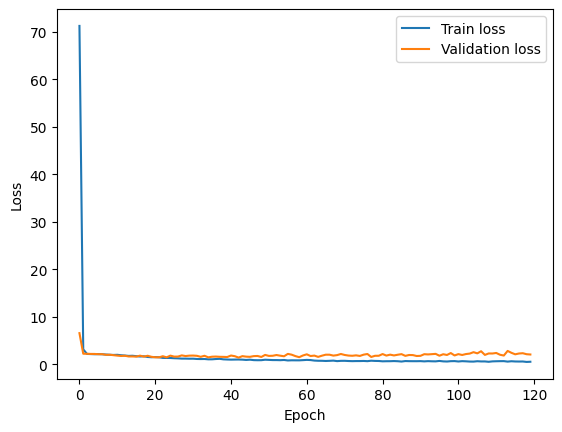

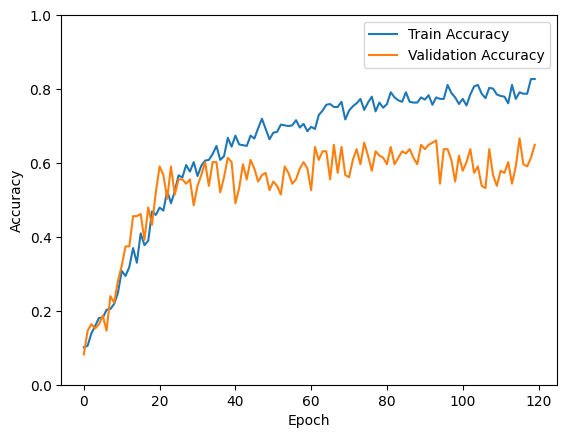

In [ ]:
# Visualize the Results
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()

In [ ]:
model_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 297, 297, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 148, 148, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1401856)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     179,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 538,321,949 (2.01 GB)

 Trainable params: 179,440,649 (684.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 358,881,300 (1.34 GB)

### Model Resnet

In [ ]:
# model Resnet

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255, input_shape=(299, 299, 3)),  # Normalize RGB
    tf.keras.layers.RandomFlip("horizontal"),  # Flip horizontally
    tf.keras.layers.RandomRotation(0.2),       # Rotate
    tf.keras.layers.RandomZoom(0.2),           # Zoom
    tf.keras.layers.RandomTranslation(0.1, 0.1),  # Translate
])

# Use Transfer Model ResNet50
resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)


resnet.trainable = False

# Define Model
model_resnet = Sequential([
    data_augmentation,
    resnet,
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(len(categories), activation='softmax')
])


# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_resnet.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Model
history_resnet = model_resnet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=1
)

# Save the Model
model_resnet.save('model_resnet.keras')


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 579ms/step - accuracy: 0.1010 - loss: 2.6341 - val_accuracy: 0.1287 - val_loss: 2.1972
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step - accuracy: 0.1351 - loss: 2.1982 - val_accuracy: 0.1287 - val_loss: 2.1972
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 552ms/step - accuracy: 0.1412 - loss: 2.1978 - val_accuracy: 0.1287 - val_loss: 2.1971
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 438ms/step - accuracy: 0.1026 - loss: 2.1970 - val_accuracy: 0.1404 - val_loss: 2.1970
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 443ms/step - accuracy: 0.1358 - loss: 2.1969 - val_accuracy: 0.1404 - val_loss: 2.1969
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 549ms/step - accuracy: 0.1493 - loss: 2.1967 - val_accuracy: 0.1404 - val_loss: 2.1968
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - accuracy: 0.1343 - loss: 2.1969 - val_accuracy: 0.1404 - val_loss: 2.1967
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - accuracy: 0.1348 - loss: 2.1967 - val_accuracy

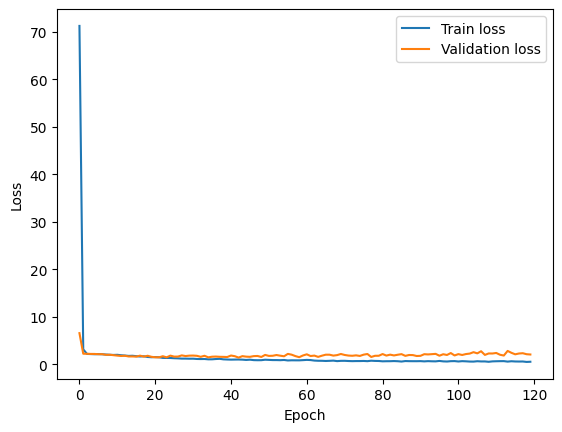

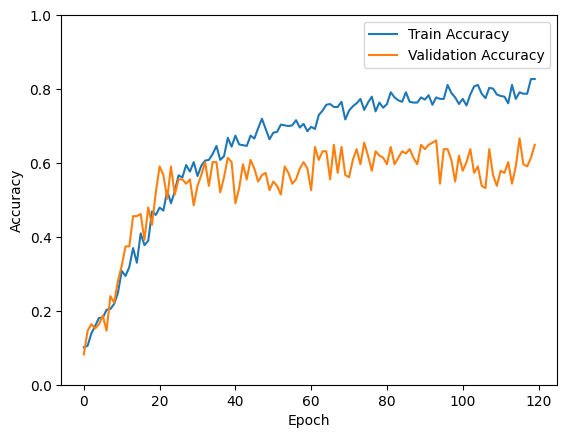

In [ ]:
# Visualize the Results
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()

In [ ]:
model_resnet.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 10, 10, 2048)        │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │       6,553,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 9)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,250,653 (164.99 MB)

 Trainable params: 6,554,313 (25.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 13,108,628 (50.01 MB)

### Model Xception

In [ ]:
# model Xception

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1.0 / 255, input_shape=(299, 299, 3)),       # RGB normalize
    layers.RandomFlip("horizontal"),   # 좌우 반전
    layers.RandomRotation(0.2),        # 회전
    layers.RandomZoom(0.2),            # 확대, 축소
    layers.RandomTranslation(0.1, 0.1),  # 좌우 이동
    ])

# Define Model

# Use Transfer Model Xception
xtn = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)

xtn.trainable=False

model_xtn = Sequential([
    data_augmentation,
    xtn,
    Flatten(),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dropout(0.1),
    Dense(len(categories),activation = 'softmax')
    ])


# Compile Model
# Use Adam optimizer
model_xtn.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy']
             )

# Train
history = model_xtn.fit(train_dataset,
         validation_data = val_dataset,
         epochs=60,
         verbose=1)

model_xtn.save('model_xtn.keras')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 617ms/step - accuracy: 0.1431 - loss: 4.8713 - val_accuracy: 0.4035 - val_loss: 1.5737
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 506ms/step - accuracy: 0.3416 - loss: 1.8856 - val_accuracy: 0.4094 - val_loss: 1.5968
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step - accuracy: 0.3735 - loss: 1.6901 - val_accuracy: 0.5439 - val_loss: 1.1999
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - accuracy: 0.4571 - loss: 1.4661 - val_accuracy: 0.5965 - val_loss: 1.1108
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 566ms/step - accuracy: 0.4702 - loss: 1.4730 - val_accuracy: 0.6199 - val_loss: 1.2122
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.5597 - loss: 1.2987 - val_accuracy: 0.6199 - val_loss: 1.0784
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 580ms/step - accuracy: 0.5493 - loss: 1.2861 - val_accuracy: 0.6199 - val_loss: 0.9492
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 467ms/step

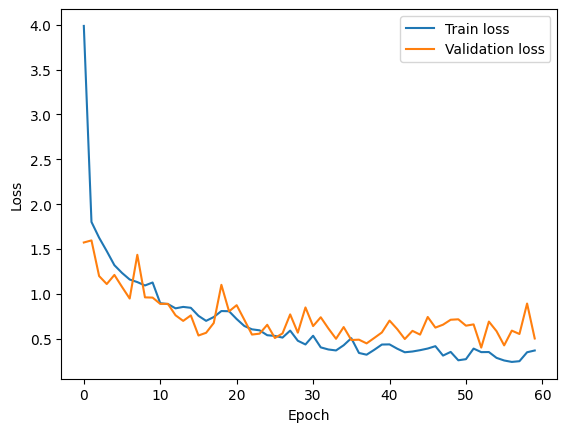

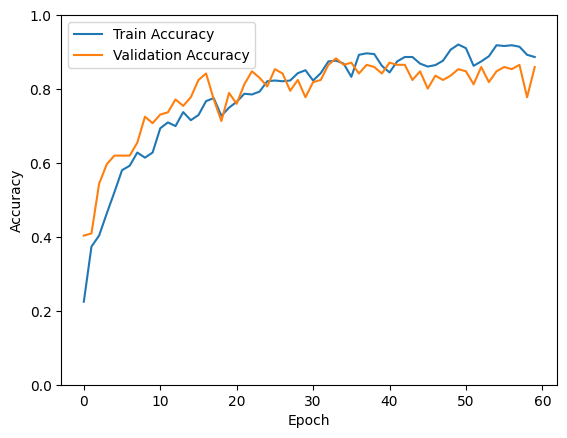

In [ ]:
# Visualize the Results
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()

In [ ]:
model_xtn.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │       6,553,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 9)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,524,421 (154.59 MB)

 Trainable params: 6,554,313 (25.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 13,108,628 (50.01 MB)

### Best Model Performance

In [ ]:
# 가장 정확도가 높은 최종 모델로 Test accuracy 확인
model = model_xtn

# test_dir path
test_dir = './dataset/test'
test_dataset = image_dataset_from_directory(
    directory=test_dir,
    image_size=(299, 299),
    label_mode='categorical',
    shuffle=True,
    seed=123,
    batch_size=64
)

# Extract images and labels after shuffling
images, labels = [], []
for img_batch, label_batch in test_dataset:
    images.append(img_batch.numpy())
    labels.append(label_batch.numpy())

# Concatenate all batches into a single array
images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)

# Convert labels from one-hot encoding to indices
actual_labels = np.argmax(labels, axis=1)

# Predict shuffled images
predicted_probs = model.predict(images)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Compute accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {accuracy:.4f}")

Found 173 files belonging to 9 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step
Test Accuracy: 0.8150


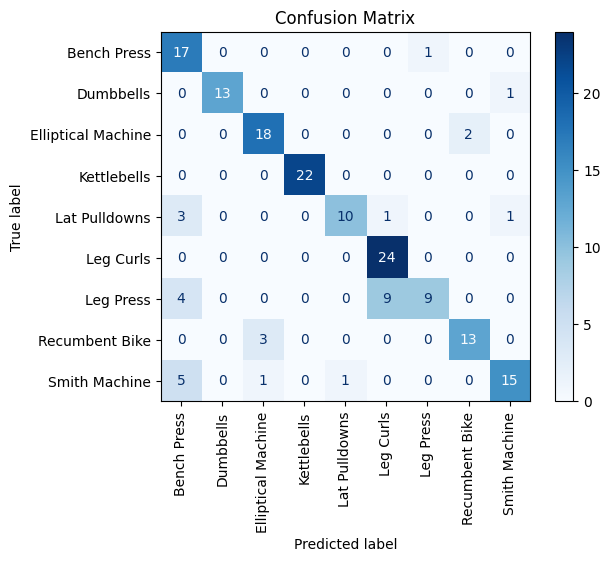

In [ ]:
# Confusion Matrix

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

# Customize plot
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(actual_labels, predicted_labels, target_names=test_dataset.class_names)
print(report)

                    precision    recall  f1-score   support

       Bench Press       0.59      0.94      0.72        18
         Dumbbells       1.00      0.93      0.96        14
Elliptical Machine       0.82      0.90      0.86        20
       Kettlebells       1.00      1.00      1.00        22
     Lat Pulldowns       0.91      0.67      0.77        15
         Leg Curls       0.71      1.00      0.83        24
         Leg Press       0.90      0.41      0.56        22
    Recumbent Bike       0.87      0.81      0.84        16
     Smith Machine       0.88      0.68      0.77        22

          accuracy                           0.82       173
         macro avg       0.85      0.82      0.81       173
      weighted avg       0.85      0.82      0.81       173



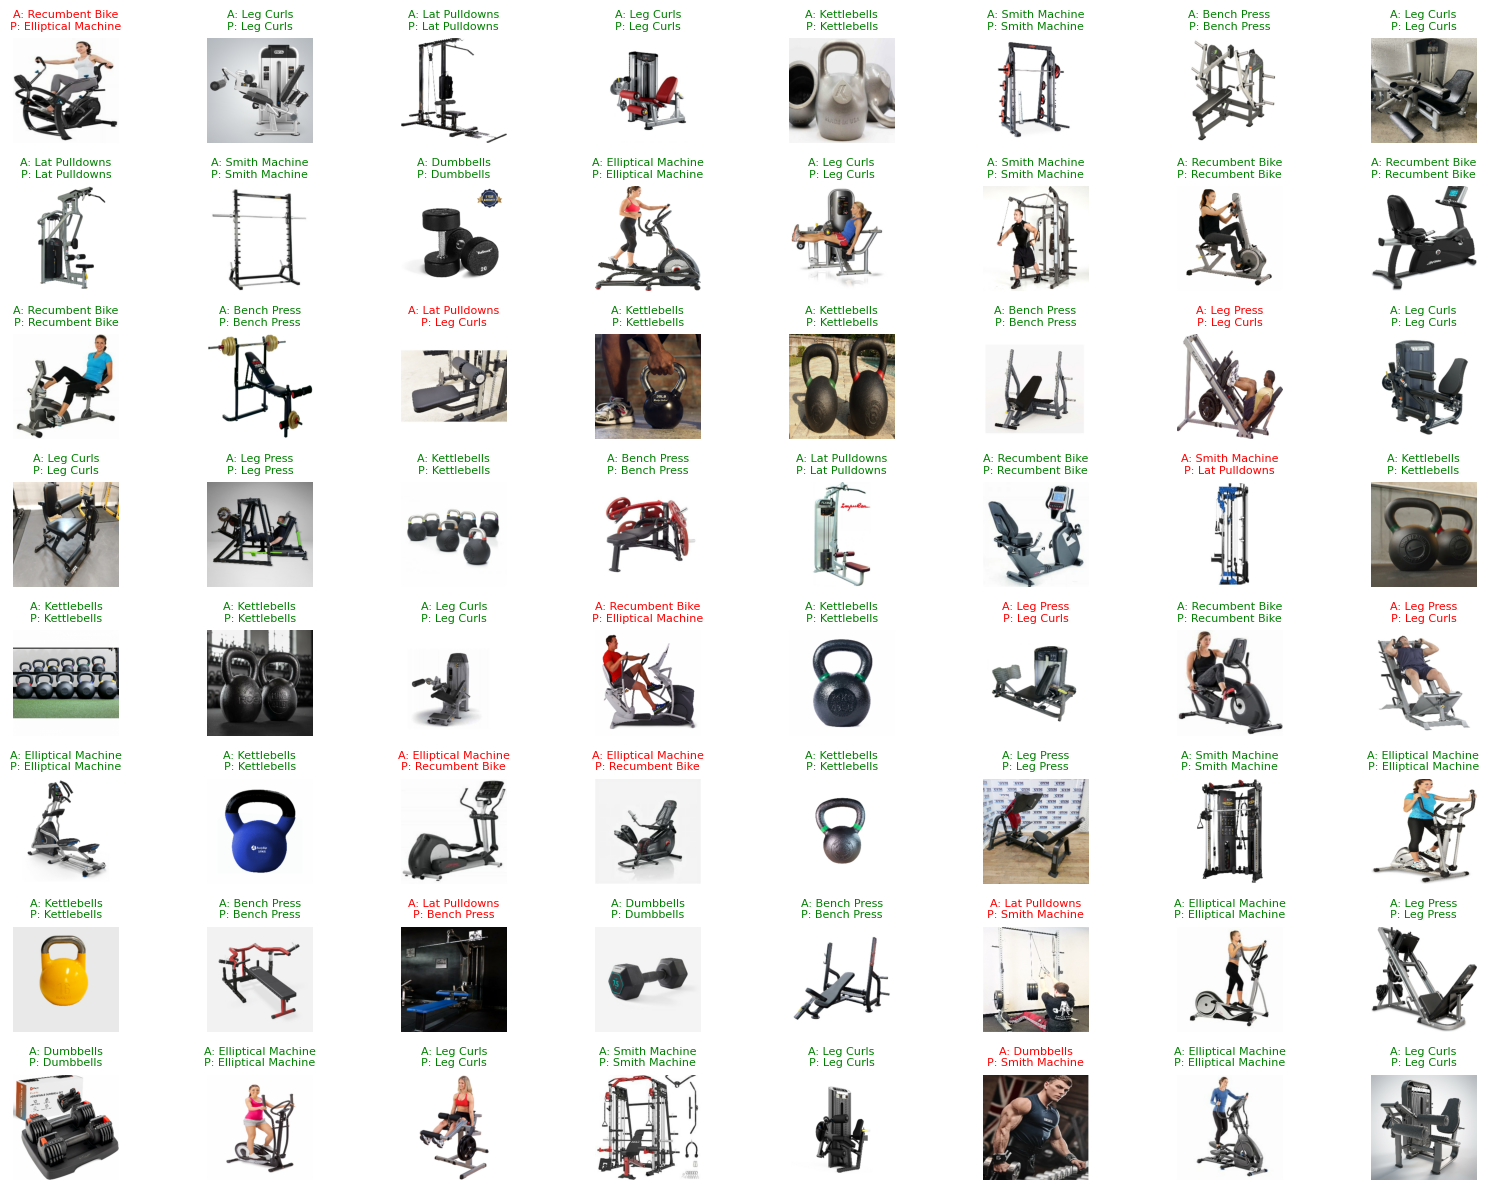

In [ ]:
# Visualize 64 images with their actual and predicted labels
plt.figure(figsize=(16, 12))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(images[i].astype("uint8"))
    actual_label = categories[actual_labels[i]]
    predicted_label = categories[predicted_labels[i]]
    color = "green" if actual_label == predicted_label else "red"
    plt.title(f"A: {actual_label}\nP: {predicted_label}", color=color, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()



### Predict Sample Image

In [ ]:
# User로부터 받은 하나 혹은 그 이상의 이미지를 best-model로 predict
sample_dir = '/content/drive/MyDrive/gym_picture_sample/'

sample_dataset = image_dataset_from_directory(
    directory=sample_dir,
    image_size=(299, 299),
    label_mode='categorical',
    shuffle=False,
    batch_size=1
)

# Get category (class) names from the training dataset
classes = train_dataset.class_names
print("Categories:", classes)

# Make predictions
y_pred = np.argmax(model.predict(sample_dataset), axis=1)

# Print predicted labels
for idx, pred in enumerate(y_pred):
    print(f"Predicted Label for sample {idx}: {classes[pred]}")


Found 4 files belonging to 4 classes.
Categories: ['Bench Press', 'Dumbbells', 'Elliptical Machine', 'Kettlebells', 'Lat Pulldowns', 'Leg Curls', 'Leg Press', 'Recumbent Bike', 'Smith Machine']
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted Label for sample 0: Bench Press
Predicted Label for sample 1: Kettlebells
Predicted Label for sample 2: Leg Curls
Predicted Label for sample 3: Elliptical Machine
